In [1]:
import os
import json
import time
import pandas as pd
from src.gender import gender
from src.vycisti import vycisti
pd.set_option('display.max_columns', None)
df = pd.read_json(os.path.join("data", "filmy.json"))
with open(os.path.join("data_fixes", "opravy.json"), encoding="utf-8") as opravy:
    opravy = json.loads(opravy.read())
with open(os.path.join("data_fixes", "seznamy.json"), encoding="utf-8") as seznamy:
    seznamy = json.loads(seznamy.read())
with open(os.path.join("data_fixes", "zeny.json"), encoding="utf-8") as zeny:
    zeny = json.loads(zeny.read())
with open(os.path.join("data_fixes", "nelide.json"), encoding="utf-8") as nelide:
    nelide = json.loads(nelide.read())
df = vycisti(df, opravy)

2023/05/25 21:38:04 z 4532 filmů odstraněno 125. Aktuální dataframe obsahuje 4407 filmů.


## Dlouhý výpočet, kterým se nechceme zdržovat v sešitu věnovaném tvůrcům

In [2]:
profese = seznamy["profese"]
persony = pd.read_json(os.path.join("data", "persony.json"))
jmena_lidi = persony[persony["Osoba"] == "fyzická"]["Jméno"].to_list()

In [3]:
profese.remove("Účinkují")
profese.remove("Hudba, text a zpěv písně")
profese.remove("Hudba k písni")

In [4]:
def plose_jednoduse(x):
    seznam = []
    for y in x:
        if y == None:
            pass
        if isinstance(y, str):
            if y not in seznam:
                seznam.append(y)
        if isinstance(y, list):
            for z in y:
                if z not in seznam:
                    seznam.append(z)
    return(seznam)

In [5]:
def kolik_skoncilo(konce, jmena_lidi):
    st = time.time()
    konce["Lidé"] = konce[profese].values.tolist()
    konce["Lidé"] = konce["Lidé"].apply(lambda x: plose_jednoduse(x))
    konce = konce[["Copyright","Lidé","Film"]].explode("Lidé")
    konce = konce[konce["Lidé"].isin(jmena_lidi)]
    konce = konce.groupby("Copyright")["Lidé"].apply(lambda x: list(set(x)))
    konce = pd.DataFrame(konce).explode("Lidé")
    konce = konce.reset_index()  
    print(f"{len(konce)} člověkoletopočtů")
    konce["Příští film"] = konce[["Lidé","Copyright"]].apply(lambda x: konce[(konce["Lidé"] == x["Lidé"]) & (konce["Copyright"] > x["Copyright"])]["Copyright"].min(), axis = 1)
    konce = konce.rename(columns={"Lidé": "Jméno"})
    konce["Pauza"] = konce["Příští film"] - konce["Copyright"]
    print(f"čas výpočtu: {time.time() - st} s")
    return(konce)

In [6]:
konce = kolik_skoncilo(df, jmena_lidi)

94896 člověkoletopočtů
čas výpočtu: 1096.2808938026428 s


In [7]:
konce.to_json(os.path.join("data", "pauzy.json"), orient="records")

In [10]:
konce.sample(5)

,Copyright,Jméno,Příští film,Pauza
66046,2003,Marek Tóth (11105),2009.0,6.0
32981,1973,Josef Hlinomaz (26212),1974.0,1.0
7608,1942,Jiří Sobotka (89459),1945.0,3.0
4057,1934,Josef Mach (7885),1937.0,3.0
41225,1979,František Havlíček (20158),1980.0,1.0


## Explorace

<AxesSubplot:xlabel='Copyright'>

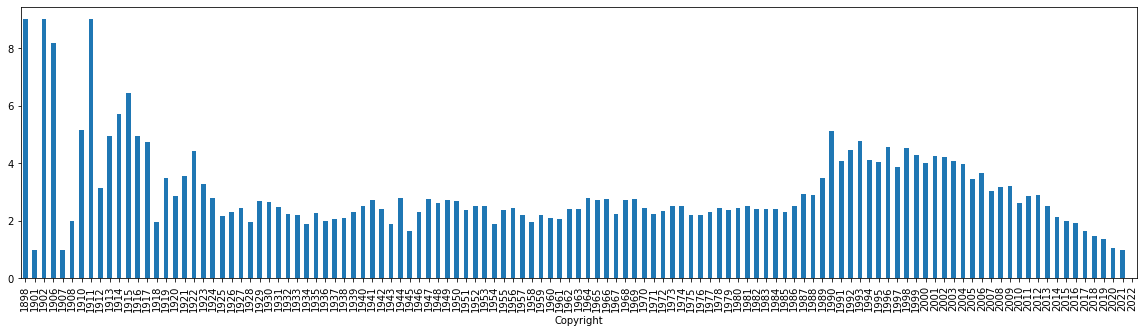

In [11]:
konce.groupby("Copyright")["Pauza"].mean().plot.bar(figsize=(20,5))

In [13]:
r3 = konce.groupby("Jméno")["Copyright"].nunique()
r3 = r3[r3 >= 5]
r3 = r3.index.to_list()

In [15]:
k3 = konce[konce["Jméno"].isin(r3)]

In [16]:
k3 = k3[k3["Copyright"].isin(range(1920,2011))]

In [18]:
k3 = k3.merge(persony[["Jméno","Rok úmrtí"]], on="Jméno")

In [19]:
k3["Příští film"] = pd.to_numeric(k3["Příští film"], errors="coerce")

In [20]:
k3["Rok úmrtí"] = pd.to_numeric(k3["Rok úmrtí"], errors="coerce")

In [21]:
k3.loc[k3["Příští film"] > k3["Rok úmrtí"],"Příští film"]=None

In [23]:
k3.groupby("Copyright")["Jméno"].nunique()

Copyright
1920    113
1921    138
1922    130
1923     81
1924     78
       ... 
2006    634
2007    542
2008    699
2009    812
2010    663
Name: Jméno, Length: 91, dtype: int64

In [24]:
k3.sample(5)

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
18998,1948,Antonín Rýdl (130015),1949.0,1.0,1960.0
38240,1979,Karel Štorkán (31946),1981.0,2.0,2007.0
15134,1969,Jaroslav Jílovec (126480),NaN,NaN,1969.0
11827,1938,František Voborský (129964),1944.0,6.0,1980.0
34637,1971,Milana Melcerová (126034),1972.0,1.0,NaN


<AxesSubplot:xlabel='Copyright'>

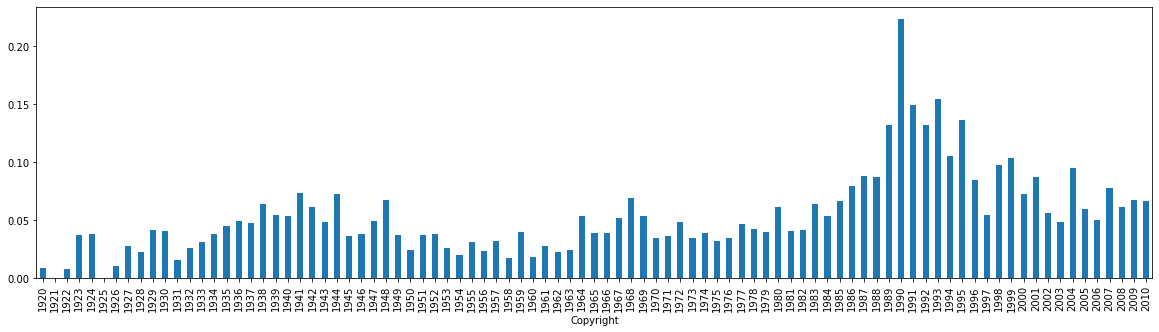

In [25]:
pd.Series(k3[k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,5))

In [29]:
k3[k3["Copyright"] == 1992]

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
9211,1992,Svatopluk Beneš (13617),2003.0,11.0,2007.0
9965,1992,Nelly Gaierová (4888),1993.0,1.0,1995.0
9966,1992,Nelly Gaierová (4888),1993.0,1.0,1995.0
11097,1992,Jiřina Bohdalová (2878),1993.0,1.0,NaN
12730,1992,Karel Černý (1241),2001.0,9.0,2014.0
...,...,...,...,...,...
60354,1992,Eva Malíková (20167),1993.0,1.0,NaN
60361,1992,Josef Viewegh (29808),1996.0,4.0,NaN
60363,1992,Ivana Šustová (88887),1993.0,1.0,NaN
60364,1992,Ivana Šustová (88887),1993.0,1.0,NaN


<AxesSubplot:xlabel='Copyright'>

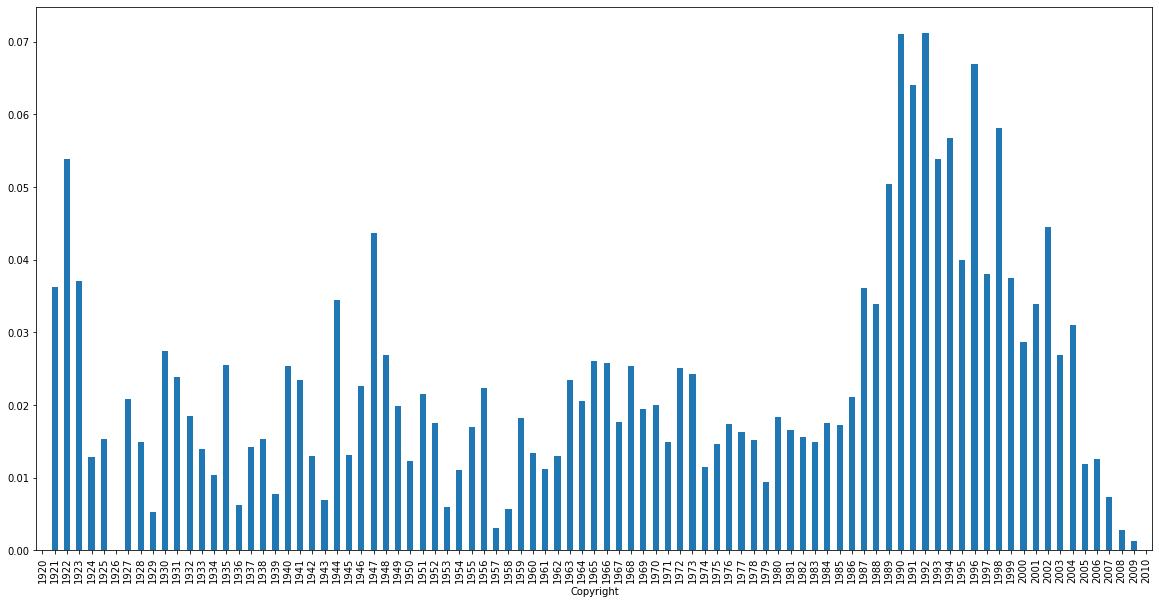

In [42]:
pd.Series(k3[(k3["Pauza"] >= 12)].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='Copyright'>

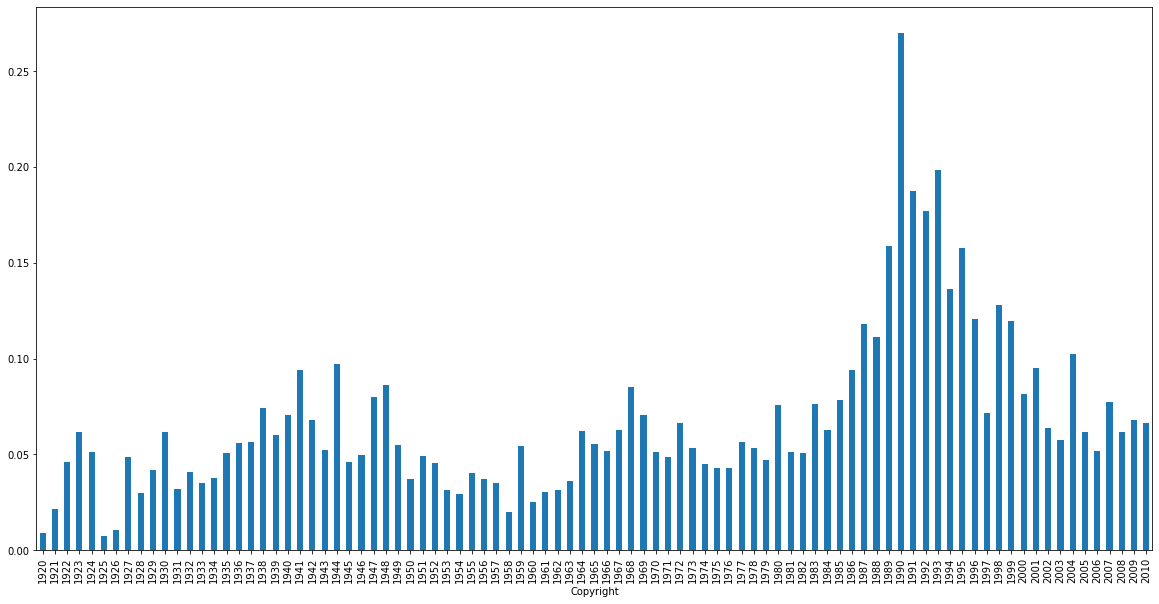

In [33]:
pd.Series(k3[(k3["Pauza"] >= 15) | (k3["Pauza"].isnull())].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='Copyright'>

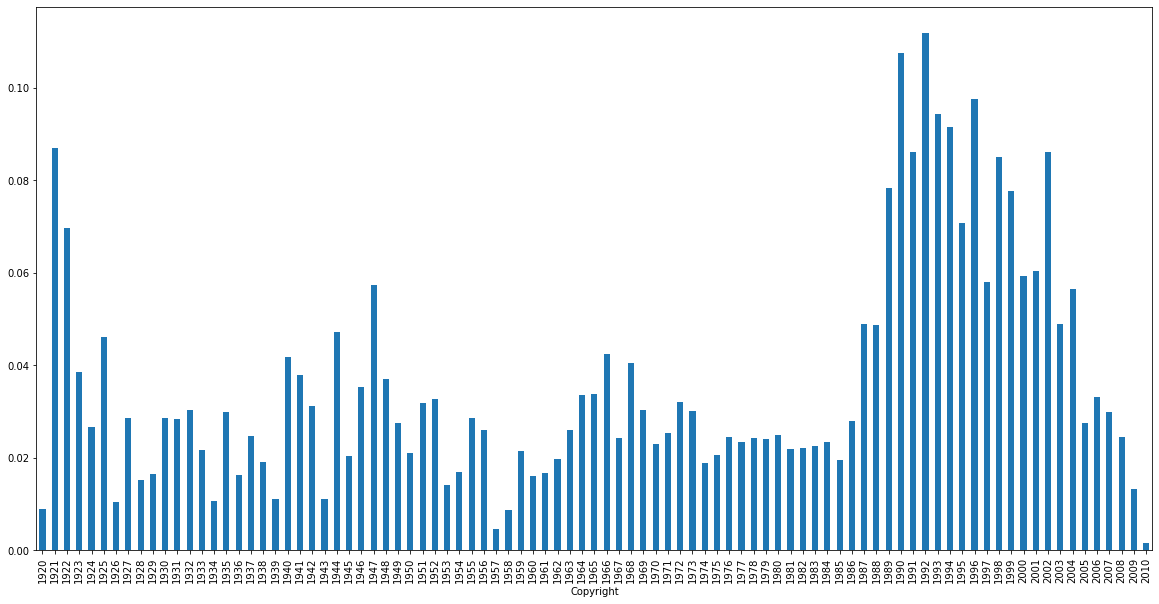

In [36]:
pd.Series(k3[(k3["Pauza"] >= 10)].groupby("Copyright")["Jméno"].nunique() / k3[~k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))